# Leverage reflectance data cube to monitor vegetation growth

This notebook illustrate how to highlight vegetation growth using a reflectance datacube.

In [1]:
import sys
import os
sys.path.append(os.path.join('..','src'))
from geosyspy.utils.constants import *
from dotenv import load_dotenv
load_dotenv()
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xarray as xr
import zarr
from azure.storage.blob import ContainerClient

## 1️⃣ Load datacube

In [2]:
account_storage = os.getenv('AZURE_ACCOUNT_NAME')
account_url = f'https://{account_storage}.blob.core.windows.net'
container_name = os.getenv('AZURE_BLOB_CONTAINER_NAME')
prefix = '2020-11-01_2021-09-15_digital_ag_field_sentinel-2-l2a_datacube.zarr'
credential = os.getenv('AZURE_SAS_CREDENTIAL')

container_client = ContainerClient(account_url=account_url, container_name=container_name, credential=credential)
store = zarr.ABSStore(client=container_client, prefix=prefix)
cube = xr.open_zarr(store=store, consolidated=True)

## 2️⃣ NDVI index to plot the field vegetation

In [3]:
# NDVI formula
def NDVI(red,nir):
    return  ((nir - red)/(nir + red))

In [4]:
#selection of dates
datacube_season_1 = cube.sel(time=slice('2020-11-26T00:00:00.000000000','2021-09-12T00:00:00.000000000'))

#NDVI images computing for all dates
dates_1=[]
NDVIs=[]
for date,cube_date in datacube_season_1.groupby('time'):
    NDVIs.append(NDVI(cube_date.red,cube_date.nir08))
    dates_1.append(date)
print(len(NDVIs))

18


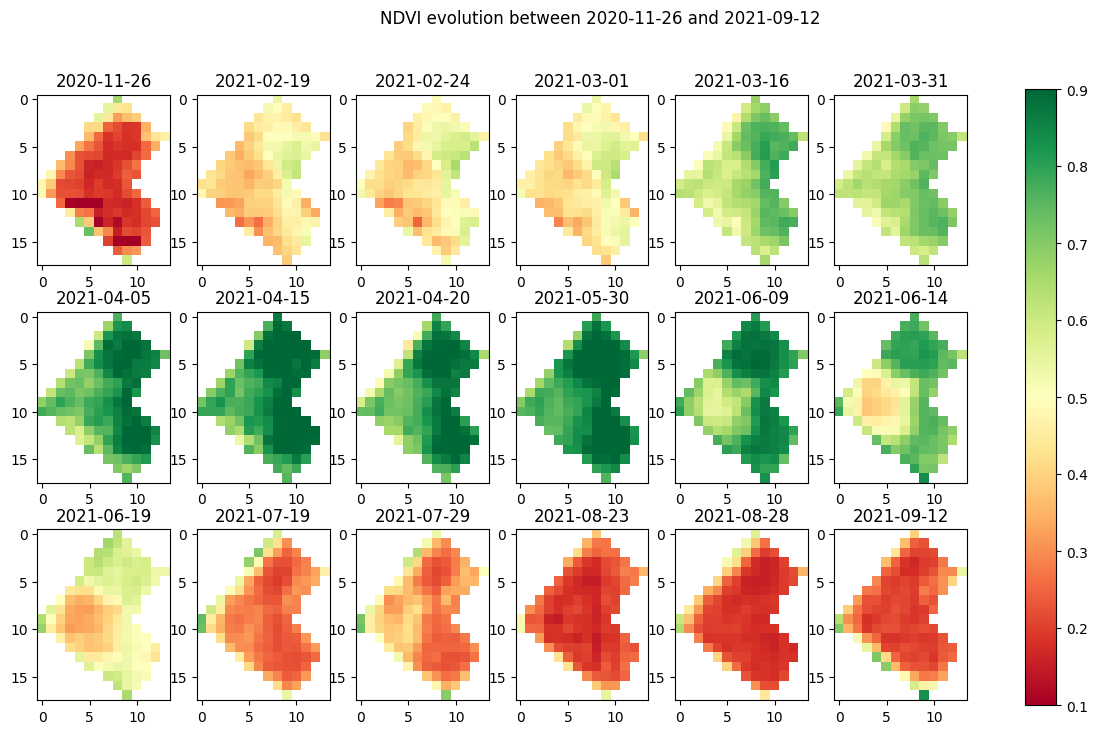

In [5]:
import matplotlib as mpl

fig, axes = plt.subplots(nrows=3, ncols=6,figsize=(15, 8))
fig.suptitle(f'NDVI evolution between {str(dates_1[0])[:10]} and {str(dates_1[-1])[:10]}')
i=0
for ax in axes.flat:
    ax.set_title(str(dates_1[i])[0:10])
    im = ax.imshow(NDVIs[i],vmin=0.1,vmax=0.9,cmap='RdYlGn')
    i+=1
    
cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
plt.colorbar(im, cax=cax, fraction=0.046, pad=0.04)

plt.show()

From what we can see here, vegetation really emergesat the end of March. Before that, it's actually harder to spot any vehetation growth on the field. To see more difference, we can use the MSAVI index which will have more insights on what's happening before the full vegetation period.

 ## 3️⃣ MSAVI index for low vegetated fields

To properly use the MSAVI index, we need to select the time for our cube before anything happens until the fully vegetated step, which we can see on April 15th 2021. We are going to compute the MSAVI index for all the dates to study the difference in growth vegetation in early stages.

In [6]:
#MSAVI formula
def MSAVI(red,nir):
    return((2*nir +1 - np.sqrt((2*nir+1)**2 - 8*(nir - red)))/2)

In [7]:
#selection of dates
datacube_season_2 = cube.sel(time=slice('2020-11-26T00:00:00.000000000','2021-09-12T00:00:00.000000000'))

#NDVI images computing for all dates
dates_2=[]
MSAVIs = []
for date,cube_date in datacube_season_2.groupby('time'):
    MSAVIs.append(MSAVI(cube_date.red,cube_date.nir08))
    dates_2.append(date)
print(len(MSAVIs))

18


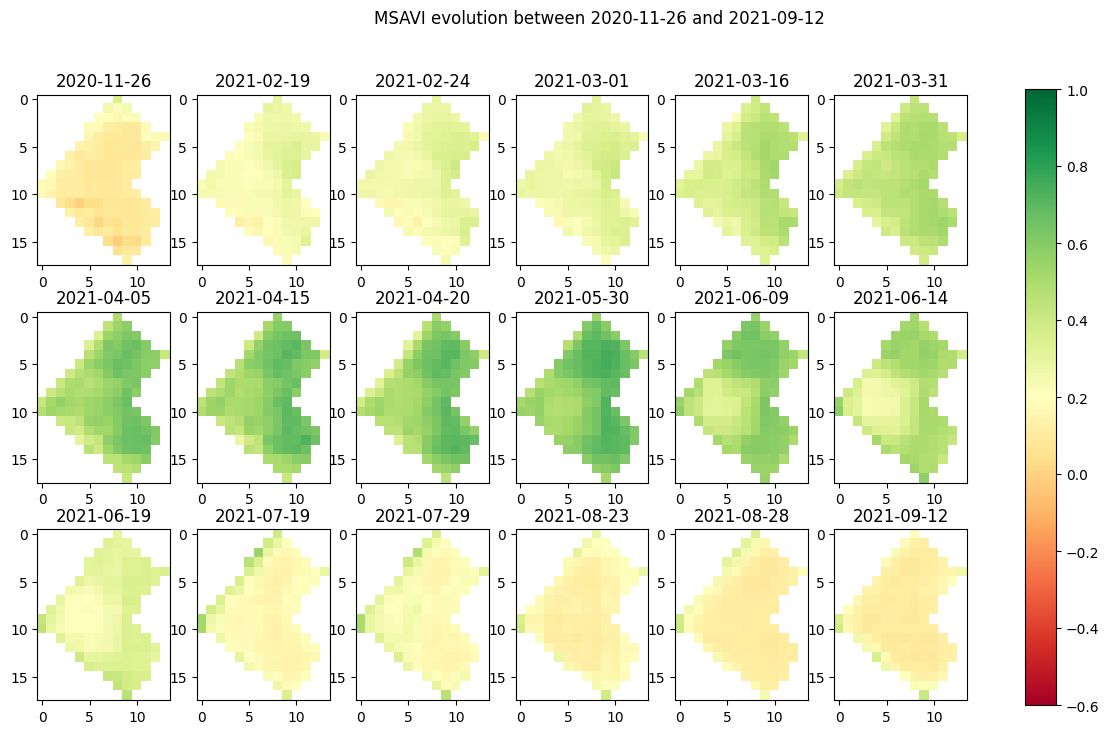

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=6,figsize=(15, 8))
fig.suptitle(f'MSAVI evolution between {str(dates_2[0])[:10]} and {str(dates_2[-1])[:10]}')
i=0
for ax in axes.flat:
    ax.set_title(str(dates_2[i])[0:10])
    im = ax.imshow(MSAVIs[i],vmin=-0.6,vmax=1,cmap='RdYlGn')
    i+=1
    
cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
plt.colorbar(im, cax=cax, fraction=0.046, pad=0.04)

plt.show()

The MSAVI index allow us to see more differences in the fields when the vegetation is low. We can see that the growth is uneven and it allows us to see that the growth mostly start on right side of the field. After the vegetation peak, the MSAVI index is saturating and that's when we can use NDVI to actually spot differences on the vegetation health.

The different spectral indexes in general allow us to see intra field variability during the different phenology key stages such as emergence, flowering or even harvest.